In [16]:
import os
import shutil
import urllib.request
import zipfile
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Step 1: Download and extract the dataset
dataset_url = 'https://archive.ics.uci.edu/static/public/773/defungi.zip'
dataset_dir = './defungi_dataset'

# Download the dataset
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    
# Check if the dataset is already downloaded, if not, download it
dataset_zip_path = os.path.join(dataset_dir, 'defungi.zip')
if not os.path.exists(dataset_zip_path):
    urllib.request.urlretrieve(dataset_url, dataset_zip_path)

# Extract the zip file
if not os.path.exists(os.path.join(dataset_dir, 'defungi')):
    with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)

In [17]:
from torchvision import datasets, transforms

# Define transformations (you can modify these as needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to 224x224 (common for pretrained models)
    transforms.ToTensor(),          # Convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet standards
])

# Create the dataset
DATA_DIR = './defungi_dataset'

dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)

# Check class-to-index mapping
print("Class to Index Mapping:", dataset.class_to_idx)

# Check the length of the dataset and an example data point
print("Dataset size:", len(dataset))

# number of classes
num_classes = len(dataset.classes)
print("Number of classes:", num_classes)

Class to Index Mapping: {'H1': 0, 'H2': 1, 'H3': 2, 'H5': 3, 'H6': 4}
Dataset size: 9114
Number of classes: 5


In [ ]:
dataset[0]

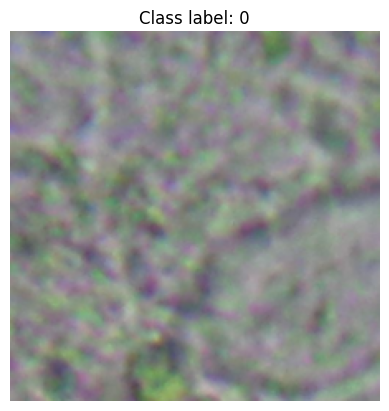

In [19]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Extract a sample image and its label from the dataset
image, label = dataset[0]

def plot_image(image, label):
  # Reverse the normalization to display the image correctly
  unnormalize = transforms.Normalize(
      mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
      std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
  )

  image = unnormalize(image)

  # Convert the image tensor to a NumPy array and transpose it for plotting
  image = image.permute(1, 2, 0).numpy()

  # Plot the image using matplotlib
  plt.imshow(image)
  plt.title(f'Class label: {label}')
  plt.axis('off')  # Hide the axes
  plt.show()

plot_image(image, label)

In [20]:
from torch.utils.data import random_split, DataLoader

train_dataset, temp_dataset = train_test_split(dataset, test_size=0.4)
val_dataset, test_dataset = train_test_split(temp_dataset, test_size=0.5)

# Create data loaders for each subset
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
# Check the number of samples in each subset
print(f'Training samples: {len(train_loader.dataset)}')
print(f'Validation samples: {len(val_loader.dataset)}')
print(f'Test samples: {len(test_loader.dataset)}')

Training samples: 5468
Validation samples: 1823
Test samples: 1823


In [40]:
# Step 3: Load the pre-trained VGG-19 model
model = models.vgg16(pretrained=True)

# Freeze all layers in the model
for param in model.parameters():
    param.requires_grad = False

# Modify the final layer to match the number of classes in the Defungi dataset
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, num_classes)

# Step 4: Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Device:", device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda


In [41]:
#model summary
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [42]:
# Step 5: Training the model
num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels).item()
        total_preds += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct_preds / total_preds

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    # Step 6: Validate the model
    model.eval()
    val_loss = 0.0
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels).item()
            total_preds += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct_preds / total_preds
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

Epoch [1/25], Train Loss: 0.8995, Train Accuracy: 0.6233
Validation Loss: 0.8295, Validation Accuracy: 0.6440
Epoch [2/25], Train Loss: 0.8006, Train Accuracy: 0.6770
Validation Loss: 0.7673, Validation Accuracy: 0.6873
Epoch [3/25], Train Loss: 0.7635, Train Accuracy: 0.6876
Validation Loss: 0.7437, Validation Accuracy: 0.7010
Epoch [4/25], Train Loss: 0.7420, Train Accuracy: 0.6953
Validation Loss: 0.7322, Validation Accuracy: 0.6967
Epoch [5/25], Train Loss: 0.7401, Train Accuracy: 0.6984
Validation Loss: 0.7107, Validation Accuracy: 0.7027
Epoch [6/25], Train Loss: 0.7228, Train Accuracy: 0.7043
Validation Loss: 0.7650, Validation Accuracy: 0.6824
Epoch [7/25], Train Loss: 0.7235, Train Accuracy: 0.7030
Validation Loss: 0.7116, Validation Accuracy: 0.6983
Epoch [8/25], Train Loss: 0.7063, Train Accuracy: 0.7132
Validation Loss: 0.7200, Validation Accuracy: 0.7093
Epoch [9/25], Train Loss: 0.7212, Train Accuracy: 0.6971
Validation Loss: 0.7000, Validation Accuracy: 0.7104
Epoch [10/

In [43]:
# Step 7: Evaluate the model on the test set
model.eval()
test_loss = 0.0
correct_preds = 0
total_preds = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels).item()
        total_preds += labels.size(0)

test_loss /= len(test_loader)
test_acc = correct_preds / total_preds
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.6735, Test Accuracy: 0.7285
